In [1]:
from collections import namedtuple
from itertools import product
import matplotlib.pyplot as plt
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from scipy.stats import entropy, multivariate_normal, norm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

In [2]:
sns.set_theme(palette='tab10')

**Содержание**<a id='toc0_'></a>    
- [__Энтропия Шеннона__](#toc1_1_)    
- [__Условная энтропия__](#toc1_2_)    
- [__Полная условная энтропия__](#toc1_3_)    
  - [__Пример на вычисление полной условной энтропии__](#toc1_3_1_)    
- [__Энтропия и прирост информации__](#toc1_4_)    
  - [__Пример на вычисление прироста информации__](#toc1_4_1_)    
- [__Алгоритм построения дерева принятия решения (ДПР)__](#toc1_5_)    
- [__Построение ДПР: тренировка на кошках__](#toc1_6_)    
- [__Бинарное дерево решений__](#toc1_7_)    
  - [__Стратегии выбора порога $C$ для некатегориального числового признака__](#toc1_7_1_)    
  - [__Стратегии выбора порога $C$ для категориального признака__](#toc1_7_2_)    
- [__Синтетический пример с числовыми предикторами__](#toc1_8_)    
- [__Неопределенность Джини и ее свойства__](#toc1_9_)    
- [__Взвешенная неопределенность Джини. Прирост Джини__](#toc1_10_)    
  - [__Пример на вычисление прироста Джини__](#toc1_10_1_)    
- [__Bank Loan Modelling__](#toc1_11_)    
- [__Линейная модель против решающего дерева__](#toc1_12_)    
- [__Переобучение__](#toc1_13_)    
- [__Неустойчивость__](#toc1_14_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Энтропия Шеннона__](#toc0_)

Первым делом при построении дерева принятия решений нужно понять, как выстроить последовательность признаков. Для этого необходимо разделить признаки на более и менее информативные.

Худшей ситуацией, с точки зрения информативности, является ситуация, когда исходы равновероятны. Лучшей - когда вероятность одного из исходов равна единице.

Пусть эксперимент $\Omega$ описывается таблицей

$$\begin{array}{c|c|c|c|c}
\Omega & \omega_1 & \omega_2 & \dots & \omega_n\\ \hline
P & P_1 & P_2 & \dots & P_n
\end{array}.$$

__Энтропией (мерой неопределенности)__ $\textbf{H}(\Omega)$ эксперимента $\Omega$ называется величина

$$\textbf{H}(\Omega) = -\sum_{i=1}^n P_i \log P_i,$$

где $\log$ - логарифм по произвольному основанию, большему единицы, а выражение $0 \log 0 = 0$ в силу того, что $\lim_{x \to 0+} x \log x = 0$. 

__Свойства энтропии__:

* Энтропия неотрицательна, $H(\Omega) \ge 0$.
* Энтропия равна нулю тогда и только тогда, когда какое-то значение $P_i$ равно единице:

$$H(\Omega) = 0 \iff \exist i \in \{1,2,\dots,n\}: P_i = 1.$$

* Энтропия $H(\Omega)$ максимальна в случае, когда исходы эксперимента равновозможны:

$$\begin{array}{c|c|c|c|c}
\Omega & \omega_1 & \omega_2 & \dots & \omega_n\\ \hline
P & \frac{1}{n} & \frac{1}{n} & \dots & \frac{1}{n}
\end{array}.$$

В этом случае энтропия равна

$$H(\Omega) = - \sum_{i=1}^n \frac{1}{n} \log \frac{1}{n} = -\log \frac{1}{n} = \log n.$$

Чем больше равновероятных исходов, тем больше энтропия, что интуитивно понятно из примера _die vs. coin_.

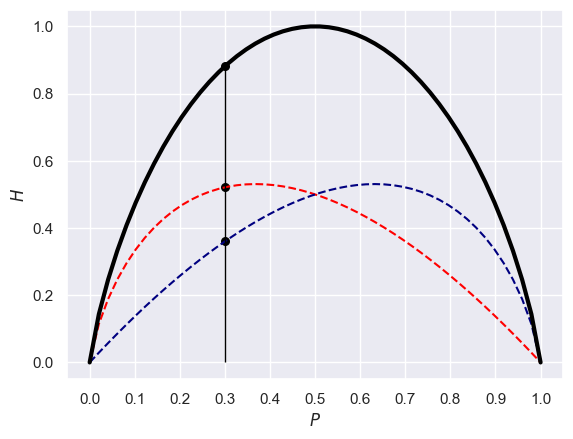

In [3]:
eps = 1e-6
x = np.linspace(eps, 1 - eps)
p = lambda x: -x*np.log2(x)
q = lambda x: -(1 - x)*np.log2(1 - x)
h = lambda x: p(x) + q(x)
plt.plot(x, p(x), '--r')
plt.plot(x, q(x), ls='--', c='navy')
plt.plot(x, h(x), 'k', lw=3)
for func in p, q, h:
    plt.scatter(0.3, func(0.3), c='k', s=30)
plt.vlines(0.3, 0, h(0.3), color='k', lw=1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('$P$')
plt.ylabel('$H$')
plt.show()

Вероятности исходов экспериментов, которые встречаются в реальной жизни, зачастую неизвестны. В таких случаях оценить вероятность каждого исхода эксперимента можно по частоте.

$$\begin{array}{c|c}
Y & N \\ \hline 
9 & 5
\end{array}$$

$$\begin{array}{c|c|c}
\Omega & Y & N \\ \hline
P & \frac{9}{14} & \frac{5}{14}
\end{array}$$

$$H(\Omega) = -\frac{9}{14} \log_2 \frac{9}{14} - \frac{5}{14} \log_2 \frac{5}{14} \approx 0.94.$$

[__scipy.stats.entropy__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.entropy.html#scipy-stats-entropy)

In [4]:
entropy([5, 9], base=2)  # нормализация предусмотрена

0.940285958670631

Энтропия близка к единице - максимуму для эксперимента, когда исходов всего 2, а основание логарифма равно двум $(\log_2 2 = 1)$.

***
## <a id='toc1_2_'></a>[__Условная энтропия__](#toc0_)

__Экспериментом__ $(\Omega,\Theta)$ назовем произвольное множество пар исходов $(\omega_i,\theta_j), i \in \{1,2,\dots,m\}, j \in \{1,2,\dots,n\}$, каждой из которых сопоставлено число $P_{ij} \ge 0$, называемое вероятностью исхода $(\omega_i,\theta_j)$, такое, что

$$\sum_{i=1}^m \sum_{j=1}^n P_{ij} = 1.$$

Пусть эксперимент $(\Omega,\Theta)$ задается таблицей

$$\begin{array}{c|c|c|c|c}
(\Omega,\Theta) & \theta_1 & \theta_2 & \dots & \theta_n \\ \hline
\omega_1 & P_{11} & P_{12} & \dots & P_{1n} \\ \hline
\omega_2 & P_{21} & P_{22} & \dots & P_{2n} \\ \hline
\dots & \dots & \dots & \dots & \dots \\ \hline
\omega_m & P_{m1} & P_{m2} & \dots & P_{mn}
\end{array}.$$

Тогда эксперименты $\Omega$ и $\Theta$ могут быть восстановлены как

$$P(\omega_i) = \sum_{j=1}^n P_{ij}, i \in \{1,2,\dots,m\} \quad \text{(axis=1)}$$

$$P(\theta_j) = \sum_{i=1}^m P_{ij}, j \in \{1,2,\dots,n\} \quad \text{(axis=0)}.$$

Может оказаться известным, что в эксперименте $\Theta$ произошло событие $\theta_j$. Тогда вероятности исходов эксперимента $\Omega$ меняются согласно формуле условной вероятности:

$$P(\omega_i|\theta_j) = \frac{P(\omega_i \cap \theta_j)}{P(\theta_j)} = \frac{P_{ij}}{P(\theta_j)},\\
i \in \{1,2,\dots,m\}, j \in \{1,2,\dots,n\}.$$

Если известно, что произошел исход $\omega_i$ эксперимента $\Omega$, вероятности исходов эксперимента $\Theta$ вычисляются как

$$P(\theta_j|\omega_i) = \frac{P(\omega_i \cap \theta_j)}{P(\omega_i)} = \frac{P_{ij}}{P(\omega_i)},\\
i \in \{1,2,\dots,m\}, j \in \{1,2,\dots,n\}.$$

Энтропия для экспериментов с новыми вероятностями:

$$H(\Omega|\theta_j) = -\sum_{i=1}^m P(\omega_i|\theta_j) \log P(\omega_i|\theta_j) = -\sum_{i=1}^m \frac{P_{ij}}{\sum_{i=1}^m P_{ij}} \log \frac{P_{ij}}{\sum_{i=1}^m P_{ij}},$$

$$H(\Theta|\omega_i) = -\sum_{j=1}^n P(\theta_j|\omega_i) \log P(\theta_j|\omega_i) = -\sum_{j=1}^n \frac{P_{ij}}{\sum_{j=1}^n P_{ij}} \log \frac{P_{ij}}{\sum_{j=1}^n P_{ij}}.$$

__Условной энтропией эксперимента $\Omega$ при условии, что эксперимент $\Theta$ оказался в состоянии__ $\theta_j$ (если произошел исход $\theta_j, j \in \{1,2,\dots,n\}$), называется величина

$$H(\Omega|\theta_j) = -\sum_{i=1}^m P(\omega_i|\theta_j) \log P(\omega_i|\theta_j).$$

***
## <a id='toc1_3_'></a>[__Полная условная энтропия__](#toc0_)

Так как каждый исход эксперимента $\Omega$ и $\Theta$ происходит с какой-то вероятностью, то и условная энтропия принимает свои значения с некоторой вероятностью. Так как $\Theta$ - эксперимент, то сумма вероятностей элементарных исходов равна единице, а значит, условная энтропия $H(\Omega|\theta_j)$ является случайной величиной с рядом распределения

$$\begin{array}{c|c|c|c}
H(\Omega|\theta_j) & H(\Omega|\theta_1) & \dots & H(\Omega|\theta_n) \\ \hline
P & P(\theta_1) & \dots & P(\theta_n)
\end{array}.$$

Случайная величина $H(\Omega|\theta_j)$, заданная выше, называется __условной энтропией эксперимента $\Omega$ при условии, что произошел эксперимент__ $\Theta$.

__Полной условной энтропией эксперимента $\Omega$ при условии, что произошел эксперимент__ $\Theta$, называется величина

$$H(\Omega|\Theta) = E(H(\Omega|\theta_j)) = \sum_{j=1}^n P(\theta_j) H(\Omega|\theta_j).$$

***
### <a id='toc1_3_1_'></a>[__Пример на вычисление полной условной энтропии__](#toc0_)

Опрос среди друзей:

In [5]:
data = np.array([[6, 0], [2, 2], [1, 3]])
weather = 'sunny', 'cloudy', 'rainy'
df = pd.DataFrame(data, index=weather, columns=['Y', 'N'])
df.index.name = 'Weather'
df.columns.name = 'Ride a bike?'
df

Ride a bike?,Y,N
Weather,,
sunny,6,0
cloudy,2,2
rainy,1,3


Условные энтропии эксперимента _Ответ_ в случаях, когда эксперимент _Погода_ оказывается соответственно в состояниях _солнечно, пасмурно, дождь_:

In [6]:
h = entropy(data, axis=1, base=2)
h

array([0.        , 1.        , 0.81127812])

Вероятности погодных состояний:

In [7]:
nobs = data.sum()  # number of observations, 14
p = data.sum(axis=1) / nobs
p  # 6/14, 4/14, 4/14

array([0.42857143, 0.28571429, 0.28571429])

Математическое ожидание полученной случайной величины

$$\begin{array}{c|c|c|c}
H(Ответ|Погода) & 0 & 1 & 0.81 \\ \hline
P & \frac{6}{14} & \frac{4}{14} & \frac{4}{14}
\end{array}$$

характеризует полную условную энтропию эксперимента _Ответ_ относительно эксперимента _Погода_:

In [8]:
p @ h

0.5175080355597522

***
## <a id='toc1_4_'></a>[__Энтропия и прирост информации__](#toc0_)

Уменьшить энтропию системы или, что то же самое, получить прирост информации можно за счет дополнительных знаний о системе. Достаточно, чтобы произошло некое событие, предшествующее проведению эксперимента, которое доопределяет эксперимент.

__Приростом информации__ (_information gain_) называется неотрицательная величина

$$\textbf{IG}(\Omega|\Theta) = H(\Omega) - H(\Omega|\Theta).$$

***
### <a id='toc1_4_1_'></a>[__Пример на вычисление прироста информации__](#toc0_)

Рассмотрим игрушечный пример, когда экспериментов (событий) больше двух, и найдем прирост информации в зависимости от различных событий. Представим конкурс кошек, которых оценивают по ряду критериев. Выясним, какой из критериев самый информативный. На что больше всего обращали внимание судьи?

In [9]:
df = pd.DataFrame({'Breed': ['british', 'british', 'british', 
                             'maine-coon', 'maine-coon', 'maine-coon', 
                             'ragdoll', 'maine-coon'],
                   'Fur': ['white', 'gray', 'white', 'white', 'brown', 
                           'brown', 'gray', 'gray'],
                   'Height': ['big', 'big', 'small', 'big', 'big', 'small', 
                              'big', 'small'],
                   'Attractive': ['N', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y']})

target, features = df.columns[-1], df.columns[:-1]
df

,Breed,Fur,Height,Attractive
0,british,white,big,N
1,british,gray,big,Y
2,british,white,small,Y
3,maine-coon,white,big,N
4,maine-coon,brown,big,Y
5,maine-coon,brown,small,N
6,ragdoll,gray,big,Y
7,maine-coon,gray,small,Y


In [10]:
def fullCondEntropy(data):
    p = data.sum(axis=1) / data.sum()
    h = entropy(data, axis=1, base=2)
    return p @ h

In [11]:
fields = 'feature', 'full_cond_entropy', 'information_gain'
EntropyInfoGainResult = namedtuple('EntropyInfoGainResult', fields)

In [12]:
base_case = entropy(df[target].value_counts(), base=2)
base_case

0.954434002924965

In [13]:
for feature in features:
    data = df.groupby(feature)[target].value_counts().unstack().fillna(0).values
    full_cond_entropy = fullCondEntropy(data)
    infogain = round(base_case - full_cond_entropy, 3)
    print(EntropyInfoGainResult(feature, round(full_cond_entropy, 3), infogain))

EntropyInfoGainResult(feature='Breed', full_cond_entropy=0.844, information_gain=0.11)
EntropyInfoGainResult(feature='Fur', full_cond_entropy=0.594, information_gain=0.36)
EntropyInfoGainResult(feature='Height', full_cond_entropy=0.951, information_gain=0.003)


Полученные значения прироста информации показывают, что критерий _Шерсть_ самый информативный: результаты оценивания жюри лучше всего соотносятся с цветом шерсти конкурсанта.

***
## <a id='toc1_5_'></a>[__Алгоритм построения дерева принятия решения (ДПР)__](#toc0_)

__Дерево принятия решений__ - это дерево, то есть ациклический связный граф, имеющее следующие метки:
* узлы дерева, не являющиеся листьями - это атрибуты;
* в листьях дерева находятся отклики - результаты классификации;
* на ребрах находится правило - значение узла (атрибута), из которого исходит ребро.

Любой путь по построенному дереву заканчивается листом, и в каждый лист можно попасть из начальной (корневой) вершины дерева. Это и есть требование _связности_ в определении.

_Ацикличность_ обеспечивается тем, что как в каждый узел (кроме изначального), так и в каждый лист входит лишь одно ребро.

__Глубиной листа__ (или узла) в дереве называется количество ребер, которые соединяют его с корневой вершиной. __Глубиной дерева__ называется максимум из глубин его листов.

Составим алгоритм построения дерева принятия решений на тренировочном наборе данных $x_1,x_2,\dots,x_n$, состоящем из $n$ элементов с $p$ предикторами $X_1,X_2,\dots,X_p$ каждый, и откликом $Y$.

1. Пусть на вход подается множество объектов $X$. Среди $p$ предикторов выбрать тот, для которого прирост информации максимален. Решается задача

$$\argmax_{Q \in \{X_1,X_2,\dots,X_p\}} IG(Y|Q)$$

2. Пусть выбран предиктор $X_i$, принимающий на наборе данных $X$ ровно $t$ уникальных значений. Выполнить разделение набора данных $X$ на подмножества $S_1,\dots,S_t$ по уникальным значениям предиктора $X_i$.

3. Для каждого множества $S_i, i \in \{1,2,\dots,t\}$, если энтропия по отклику не равна нулю, повтороить шаги $1$ и $2$. 

Это лишь одно из возможных условий остановки деления набора тренировочных данных на группы и, как следствие, одно из возможных условий остановки построения ДПР. Ситуация, когда энтропия каждой получившейся группы равна нулю означает, что в каждой группе все элементы имеют один и тот же отклик, а значит, понятно, и как эту группу "охарактеризовать" - по отклику. Разделение до нулевой энтропии вычислительно затратно и может приводить к переобучению. Поэтому часто используют следующие критерии остановки:
* ограничение глубины дерева: узлы, имеющие максимальную установленную глубину, становятся листами;
* ограничение минимального количества элементов в группе. Если при разделении рассматриваемого множества на подмножества по уникальным значениям предиктора получающиеся группы тренировочных данных содержат меньше элементов, чем задано исследователем, то деление останавливается и текущий узел становится листом;
* достижение в группе какого-то заданного критерия: например, значения неопределенности. Текущий узел также становится листом.

Лист с ненулевой энтропией обычно классифицируют голосованием большинства.

Выбранный на первом шаге алгоритма предиктор $X_i$ - это узел дерева, а разделение множества объектов на $t$ подмножеств по уникальному значению предиктора - это установление $t$ ребер из узла $X_i$. Равенство нулю энтропии для некоторого множества $S_i$ означает, что установленное ребро, в результате которого получилось множество $S_i$, указывает на лист, которому нужно присвоить значение откликов объектов из $S_i$ - ведь раз энтропия ноль, то все объекты имеют одинаковый отклик.

***
## <a id='toc1_6_'></a>[__Построение ДПР: тренировка на кошках__](#toc0_)

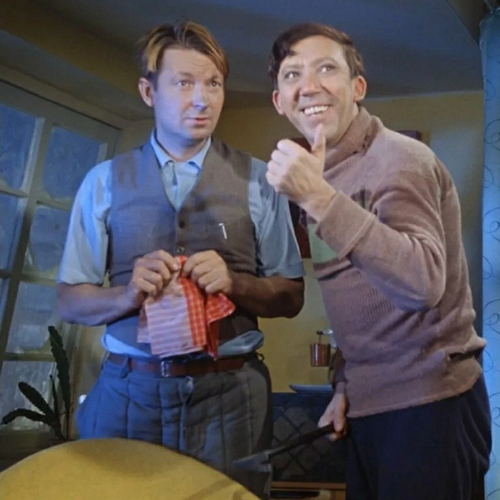

Вернемся к примеру с кошками. Каждая строка таблицы - это тренировочный объект, обладающий тремя предикторами (_Порода, Шерсть, Рост_) и откликом _Привлекательность_.

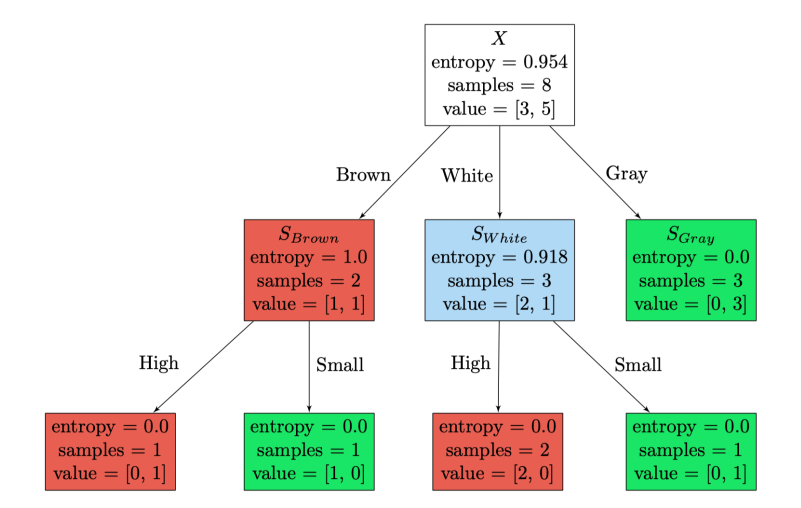

Энтропия в блоках вычислена, разумеется, по отклику. __`value`__ - разбивка __`samples`__ по отлику: количество непривлекательных и привлекательных кошек соответственно. _High_ на диаграмме автора это _big_ в датафрейме.

***
## <a id='toc1_7_'></a>[__Бинарное дерево решений__](#toc0_)

Очевидно, что приведенный выше алгоритм построения ДПР пригоден лишь для случая, когда все возможные значения предикторов присутствуют в тренировочном наборе данных, и, например, классифицировать черную кошку построенным выше деревом невозможно.

__Бинарное дерево принятия решений__ - это дерево принятия решений, из каждого узла которого выходит ровно два ребра.

Разделение всегда осуществляется на два подмножества, в каждом из которых заново рассчитывается энтропия и по проделанным расчетам определяется наиболее информативный критерий дальнейшего разбиения, если это разбиение требуется (если не достигнуто какое-нибудь терминальное условие). Объекты, значения признаков которых ранее не встречались, все равно будут отнесены к одному из двух возможных подмножеств, а значит, в итоге будут классифицированы.

Множество значений некатегориального числового признака $X_i$ делят на два множества:
$$X_i \le C, \quad X_i > C,$$
где $C$ - пороговое значение.

***
### <a id='toc1_7_1_'></a>[__Стратегии выбора порога $C$ для некатегориального числового признака__](#toc0_)

Вариантов много, приведем лишь несколько.

1. Определяют множество значений (обычно отрезок) $[a,b]$ некатегориального числового признака $X_i$, либо исходя из теоретических соображений (знания предметной области), либо исходя из значений этого признака у тренировочных данных. В качестве $a$ берут наименьшее значение признака, в качестве $b$ - наибольшее. Далее задается шаг $h > 0$ изменения значения $C$:
$$\{a, a+h, \dots, a + (k - 1)h, a + kh\}, k \in \Z,$$
где $a + (k - 1)h < b$, но $a + kh \ge b$.

Для каждого $C$ вычисляют прирост информации, отвечающий разделению на $X_i \le C, X_i > C$.

2. Значения $C$ выбираются таким образом, чтобы при каждом следующем значении $C$ к множеству $X_i \le C$ добавлялось ровно одно новое значение предиктора $X_i$. (Движение $C$ по сортированному по возврастанию ряду уникальных значений предиктора).

***
### <a id='toc1_7_2_'></a>[__Стратегии выбора порога $C$ для категориального признака__](#toc0_)

Если признак $X_i$ категориальный и принимает значения из множества $M$, то множество его значений можно разделить на две части, например, так:
$$X_i \in M_1, X_i \in M_2:$$

$$M_1 \cap M_2 = \varnothing, M_1 \cup M_2 = M, M_j \ne \varnothing, j \in \{1,2\}$$

Иными словами, все множество $M$ уникальных значений признака $X_i$ разбивается на $2$ непустые непересекающиеся части.

Чаще всего множество $M_1$ составляется ровно из одного значения признака $X_i$, тогда как $M_2$ составляется из всех остальных значений:
$$M_1 = \{C\}, \quad M_2 = M \setminus M_1,$$
где на каждой итерации $C$ принимает по очереди значения каждого элемента множества $M$. В итоге выбирают то разделение, при котором прирост информации наибольший.

Кошки:

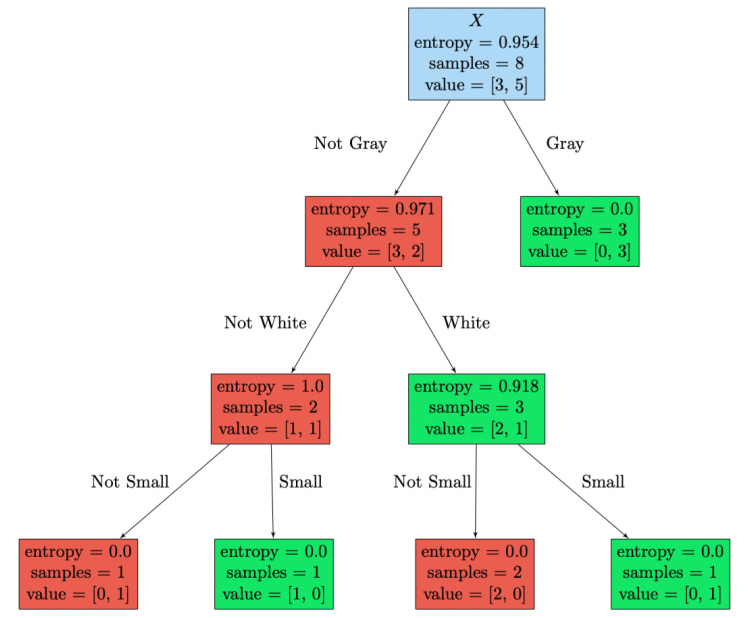

[__Passing categorical data to Sklearn Decision Tree__](https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree)

In [14]:
dummy_features = pd.get_dummies(df[features])
clf = DecisionTreeClassifier(criterion='entropy', random_state=2)
clf.fit(dummy_features, df[target])

DecisionTreeClassifier(criterion='entropy', random_state=2)

In [15]:
export_graphviz(clf, out_file='cats.gv', 
                feature_names=dummy_features.columns,
                class_names=['N', 'Y'],
                filled=True, rounded=True)

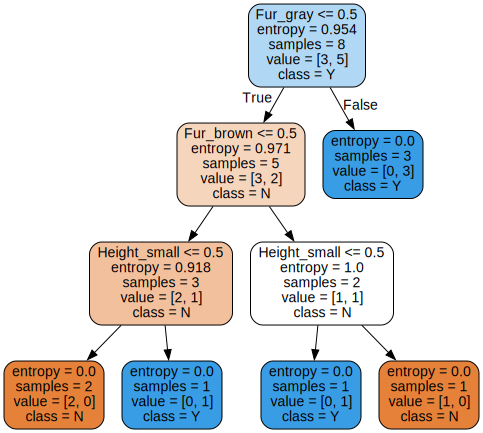

In [16]:
with open('cats.gv') as file:
    dot = file.read()

graphviz.Source(dot)

То же дерево. $\text{feature} \le 0.5$ для дамми-переменной, по сути, означает равенство нулю (отсутствие признака). Например, __`Fur_gray <= 0.5`__ означает _не серая_, и соответственно, лист на втором уровне по ребру __`False`__ означает _не не серых_ кошек, т.е. серых, или проще: __`Fur_gray = 1`__. 

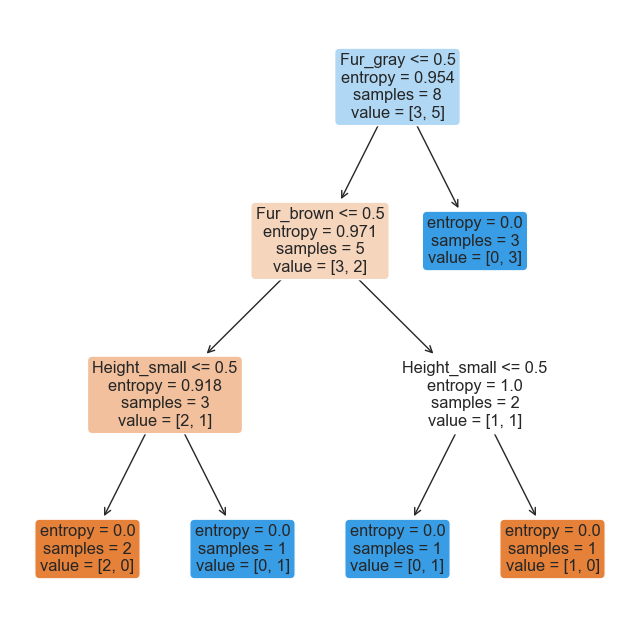

In [17]:
# без graphviz
plt.figure(figsize=(8,8))
plot_tree(clf, 
          feature_names=dummy_features.columns, 
          filled=True, rounded=True)
plt.show()

***
## <a id='toc1_8_'></a>[__Синтетический пример с числовыми предикторами__](#toc0_)

In [18]:
random_state = 2128506
size = 200
means = [5, 4], [0, 0]
covs = [[4, 0], [0, 1]], [[4, 0], [0, 2]]
colors = 'r', 'navy'

samples = [multivariate_normal.rvs(mean, cov, size, random_state=random_state)
           for mean, cov in zip(means, covs)]

data = np.r_[*samples]
y = np.array([1]*size + [-1]*size)

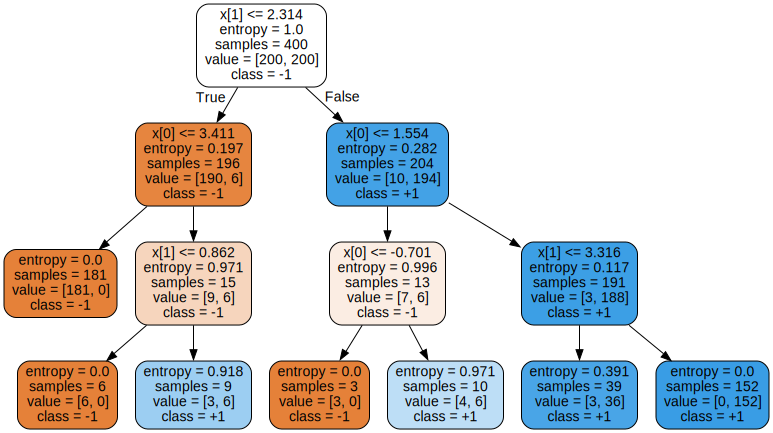

In [19]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=2)
clf.fit(data, y)

export_graphviz(clf, out_file='synth.gv',
                class_names=['-1', '+1'],
                filled=True, rounded=True)

with open('synth.gv') as file:
    dot = file.read()

graphviz.Source(dot)

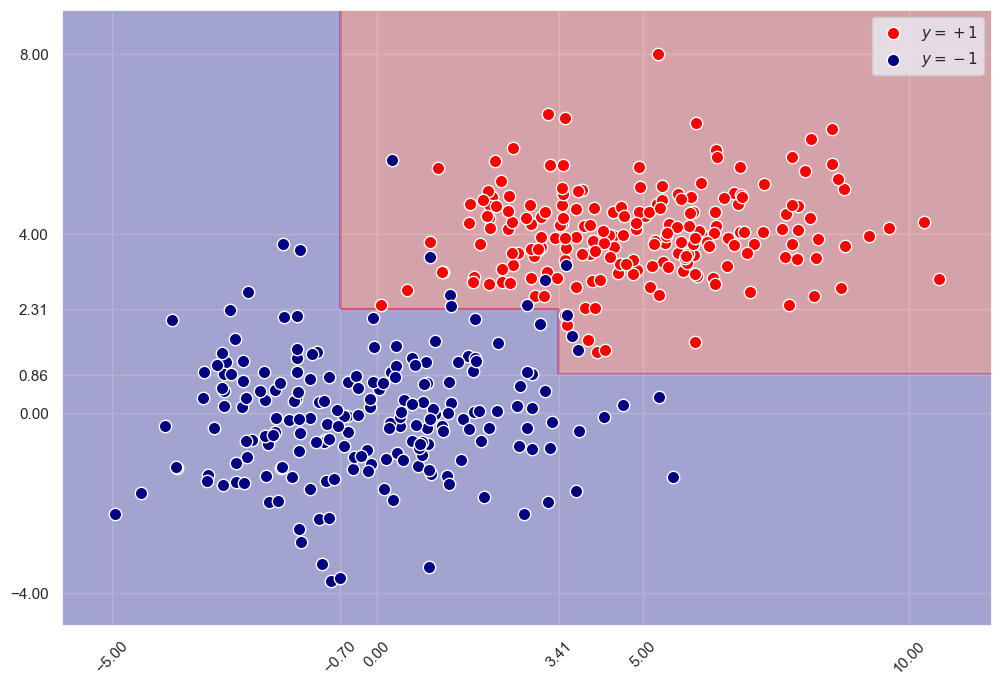

In [20]:
plt.figure(figsize=(12,8))

DecisionBoundaryDisplay.from_estimator(
    clf,
    data,
    grid_resolution=500,
    ax=plt.gca(),
    cmap='seismic', alpha=0.3,
    response_method='predict'
)

for sample, color, sign in zip(samples, colors, '+-'):
    plt.scatter(*sample.T, c=color, edgecolor='w', s=80, label=f'$y={sign}1$')

plt.xticks(list(range(-5, 11, 5)) + [-0.701, 3.411], rotation=45)
plt.yticks(list(range(-4, 9, 4)) + [0.862, 2.314])
plt.legend()
plt.show()

***
## <a id='toc1_9_'></a>[__Неопределенность Джини и ее свойства__](#toc0_)

Неопределенность Джини (_Gini impurity_) - еще один, наряду с энтропией, критерий информативности, который является мерой неправильной классификации.

Вернемся к опросу друзей. Из $14$ респондентов $9$ ответили _Да_, $5$ - _Нет_. Какова вероятность, что случайный респондент будет классифицирован неверно? Это событие распадается на два: он говорит _Да_, мы относим его к группе _Нет_, и наоборот.

$$\begin{array}{c|c|c}
\Omega & Y & N \\ \hline
P & \frac{9}{14} & \frac{5}{14}
\end{array}$$

$$P_{\text{wrong clf}} = \frac{9}{14} \cdot \frac{5}{14} + \frac{5}{14} \cdot \frac{9}{14} = \frac{90}{196}$$

Эта величина и есть неопределенность Джини или мера неправильной классификации.

Пусть эксперимент $\Omega$ описывается таблицей

$$\begin{array}{c|c|c|c|c}
\Omega & \omega_1 & \omega_2 & \dots & \omega_n\\ \hline
P & P_1 & P_2 & \dots & P_n
\end{array}.$$

__Неопределенностью Джини__ $\textbf{G}(\Omega)$ эксперимента $\Omega$ называется величина
$$\textbf{G}(\Omega) = \sum_{i=1}^n P_i (1 - P_i) = 1 - \sum_{i=1}^n P^2_i.$$

__Свойства неопределенности Джини__:
* $G(\Omega) = 0 \iff H(\Omega) = 0 \iff \exist i \in \{1,2,\dots,n\}: P_i = 1.$
* $G$ максимальна в случае, когда исходы эксперимента равновозможны:
$$G(\Omega) = 1 - \sum_{i=1}^n \frac{1}{n^2} = 1 - \frac{1}{n}.$$
* $0 \le G(\Omega) < 1$

Пусть эксперимент $(\Omega,\Theta)$ задается таблицей

$$\begin{array}{c|c|c|c|c}
(\Omega,\Theta) & \theta_1 & \theta_2 & \dots & \theta_n \\ \hline
\omega_1 & P_{11} & P_{12} & \dots & P_{1n} \\ \hline
\omega_2 & P_{21} & P_{22} & \dots & P_{2n} \\ \hline
\dots & \dots & \dots & \dots & \dots \\ \hline
\omega_m & P_{m1} & P_{m2} & \dots & P_{mn}
\end{array}.$$

__Условной неопределенностью Джини__ эксперимента $\Omega$ при условии, что эксперимент $\Theta$ оказался в состоянии $\theta_j, j \in \{1,2,\dots,n\}$, называется число
$$G(\Omega|\theta_j) = 1 - \sum_{i=1}^m P^2(\omega_i|\theta_j).$$

Для каждого состояния $\theta_j$, которое происходит с некоторой вероятностью $P(\theta_j)$, неопределенность Джини принимает значения $G(\Omega|\theta_j)$, а значит, является случайной величиной с рядом распределения
$$\begin{array}{c|c|c|c}
G(\Omega|\theta_j) & G(\Omega|\theta_1) & \dots & G(\Omega|\theta_n) \\ \hline
P(\theta_j) & P(\theta_1) & \dots & P(\theta_n)
\end{array}.$$ 

***
## <a id='toc1_10_'></a>[__Взвешенная неопределенность Джини. Прирост Джини__](#toc0_)

__Взвешенной неопределенностью Джини__ эксперимента $\Omega$ при условии, что произошел эксперимент $\Theta$, называется величина
$$G(\Omega|\Theta) = E(G(\Omega|\theta_j)) = \sum_{j=1}^n P(\theta_j) G(\Omega|\theta_j).$$

__Приростом Джини__ (_Gini Gain_) называется величина
$$\textbf{GG}(\Omega|\Theta) = G(\Omega) - G(\Omega|\Theta).$$

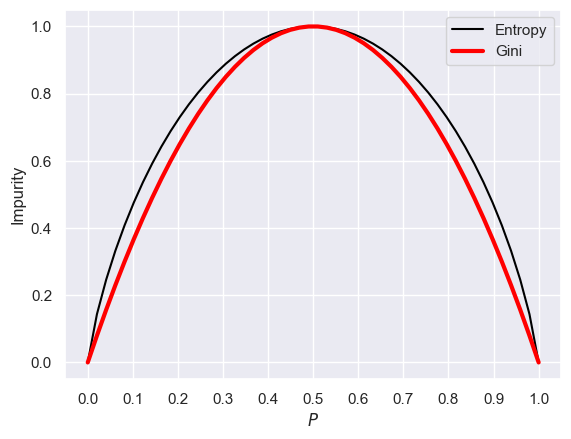

In [21]:
eps = 1e-6
x = np.linspace(eps, 1 - eps)
plt.plot(x, -x*np.log2(x) - (1 - x)*np.log2(1 - x), 'k', label='Entropy')
plt.plot(x, 2 * (1 - (x**2 + (1 - x)**2)), 'r', lw=3, label='Gini')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('$P$')
plt.ylabel('Impurity')
plt.legend()
plt.show()

Удвоение неопределенности Джини позволяет нормировать значения неопределенности до единицы, что условно "уравнивает единицы измерения".

Нет явных предпосылок использовать тот или иной метод измерения информативности, так как и энтропия, и Джини дают почти одинаковый результат. Однако вычисление энтропии вычислительно более затратно из-за логарифма. По этой причине в scikit-learn по умолчанию используется неопределенность Джини. 

***
### <a id='toc1_10_1_'></a>[__Пример на вычисление прироста Джини__](#toc0_)

Кошки:

In [22]:
df

,Breed,Fur,Height,Attractive
0,british,white,big,N
1,british,gray,big,Y
2,british,white,small,Y
3,maine-coon,white,big,N
4,maine-coon,brown,big,Y
5,maine-coon,brown,small,N
6,ragdoll,gray,big,Y
7,maine-coon,gray,small,Y


In [23]:
base_case = 1 - (df[target].value_counts(normalize=True)**2).sum()
base_case

0.46875

In [24]:
def getGiniImp(arr):
    return 1 - np.sum((arr / arr.sum())**2)

In [25]:
GiniGainResult = namedtuple('GiniGainResult', ['feature', 'Gini_gain'])

In [26]:
for feature in features:
    data = df.groupby(feature)[target].value_counts().unstack().fillna(0).values
    p = data.sum(axis=1) / data.sum()
    g = np.apply_along_axis(getGiniImp, axis=1, arr=data)
    print(GiniGainResult(feature, round(base_case - p @ g, 3)))

GiniGainResult(feature='Breed', Gini_gain=0.052)
GiniGainResult(feature='Fur', Gini_gain=0.177)
GiniGainResult(feature='Height', Gini_gain=0.002)


***
## <a id='toc1_11_'></a>[__Bank Loan Modelling__](#toc0_)

[__Source__](https://www.kaggle.com/datasets/itsmesunil/bank-loan-modelling) | Описание переменных см. в файле, вкладка _Description_.

In [27]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data',
                   index_col='ID')
df.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal Loan       5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 546.9 KB


In [29]:
X = df.drop(columns=['Personal Loan'])
y = df['Personal Loan']
random_state = 2128506

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)

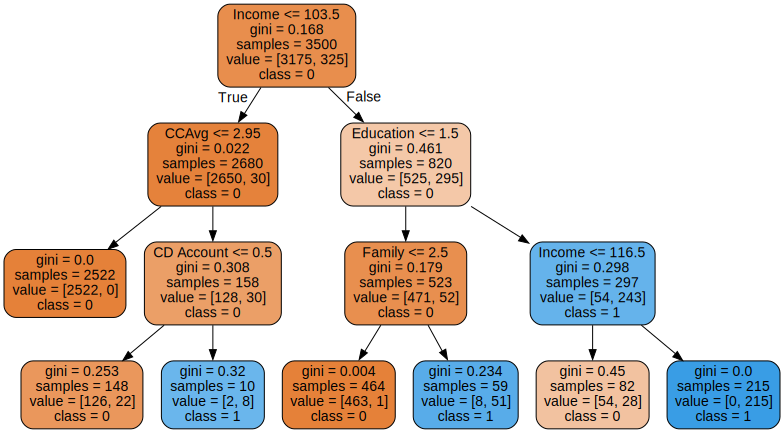

In [30]:
clf = DecisionTreeClassifier(max_depth=3, random_state=random_state)
clf.fit(X_train, y_train)

export_graphviz(clf, out_file='bank_loan.gv',
                feature_names=X.columns,
                class_names=['0', '1'],
                filled=True, rounded=True)

with open('bank_loan.gv') as file:
    dot = file.read()

graphviz.Source(dot)

Интерес представляет правый нижний лист. Кредиты берут клиенты с законченным высшим образованием или высше (например, степень), годовой доход которых более $116.5$ тыс. долларов в год. 

In [31]:
y_pred = clf.predict(X_test)

In [32]:
metrics.accuracy_score(y_test, y_pred)

0.978

In [33]:
metrics.precision_score(y_test, y_pred)

0.9420289855072463

In [34]:
metrics.recall_score(y_test, y_pred)

0.8387096774193549

In [35]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[1337,    8],
       [  25,  130]], dtype=int64)

In [36]:
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp

(1337, 8, 25, 130)

***
## <a id='toc1_12_'></a>[__Линейная модель против решающего дерева__](#toc0_)

* Когда данные хорошо линейно разделимы, лучше линейная модель.
* Когда данные плохо линейно разделимы (много сложных нелинейных зависимостей), лучше подходит модель, основанная на решающих деревьях.

In [37]:
size = 500
random_state = 3
scatter_kwargs = dict(s=90, edgecolor='w')
regions_kwargs = dict(colors='navy,r', markers='o', 
                      scatter_kwargs={'s': 80, 'edgecolor': 'w'},
                      contourf_kwargs={'alpha': 0.4},
                      contour_kwargs={'colors': 'w'})

In [38]:
def logregVsTree(X, y, case):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=random_state)
    
    clfs = (LogisticRegression(random_state=random_state),
            DecisionTreeClassifier(random_state=random_state))
    
    axs = plt.subplots(3, 1, figsize=(9,18))[1]
    colors = np.where(y, 'r', 'navy')
    axs[0].scatter(X[:,0], X[:,1], c=colors, **scatter_kwargs)

    for i, clf in enumerate(clfs, 1):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy_score = metrics.accuracy_score(y_test, y_pred)
        axs[i].set_title(f'{accuracy_score=}')
        plot_decision_regions(X_test, y_test, clf, ax=axs[i], 
                              **regions_kwargs)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.suptitle(f'Logistic Regression vs. Decision Tree: {case}')
    plt.show()

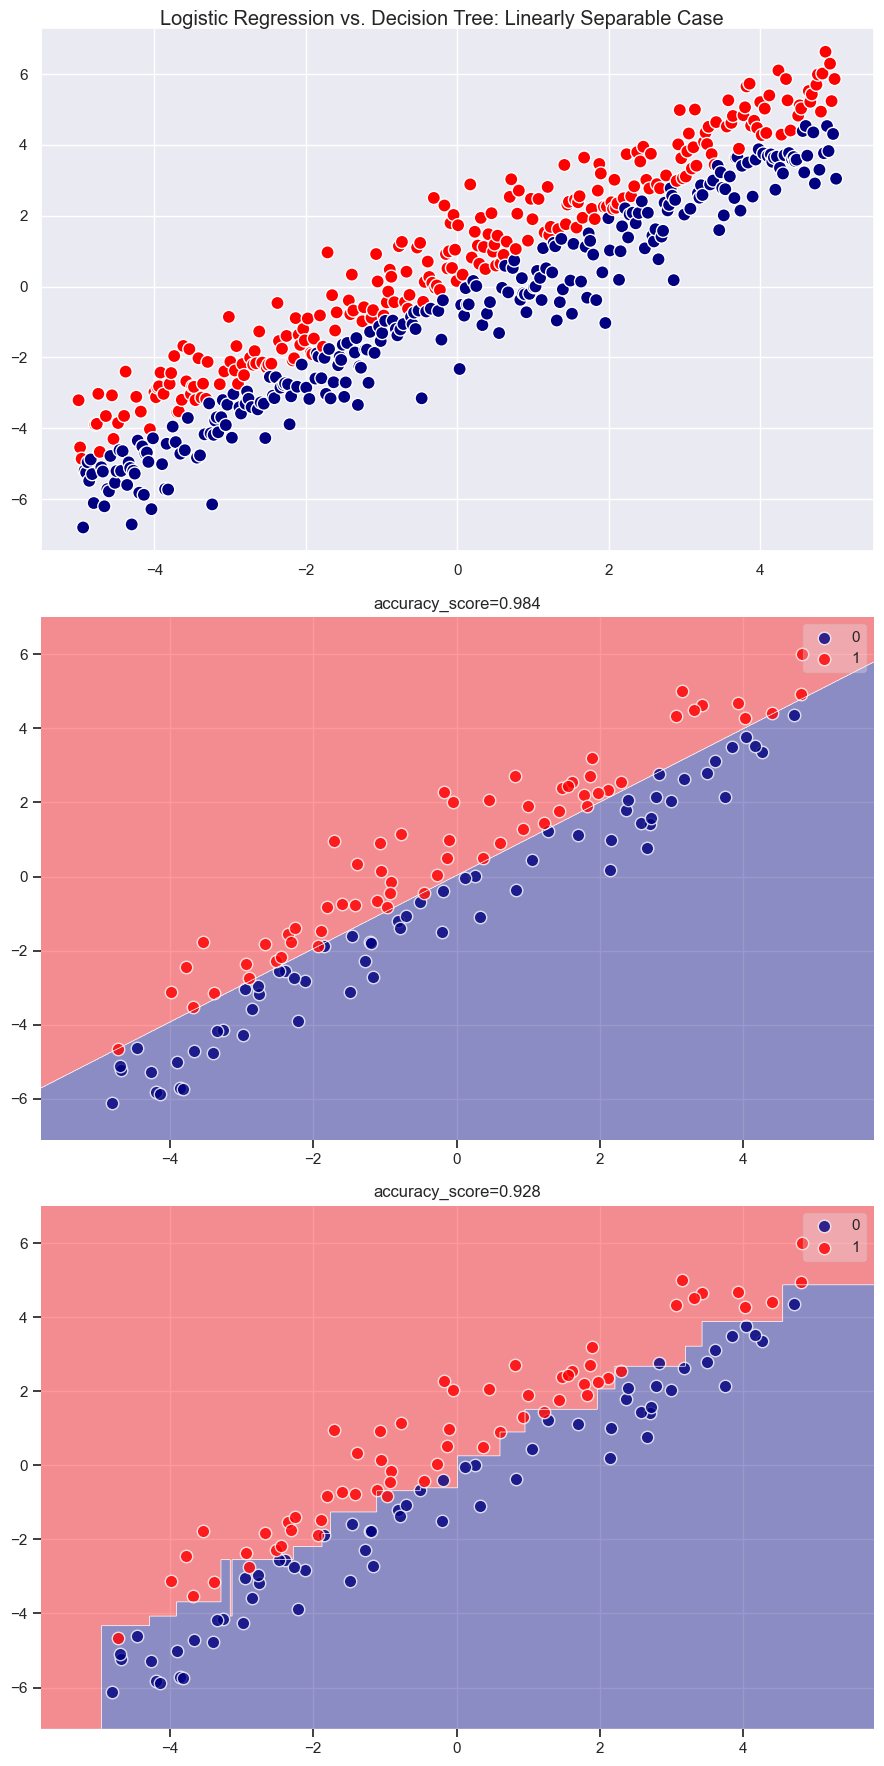

In [39]:
X = np.empty((size, 2))
X[:,0] = np.linspace(-5, 5, size)
X[:,1] = X[:,0] + norm.rvs(size=size, random_state=random_state)
y = (X[:,1] > X[:,0]).astype(int)
logregVsTree(X, y, 'Linearly Separable Case')

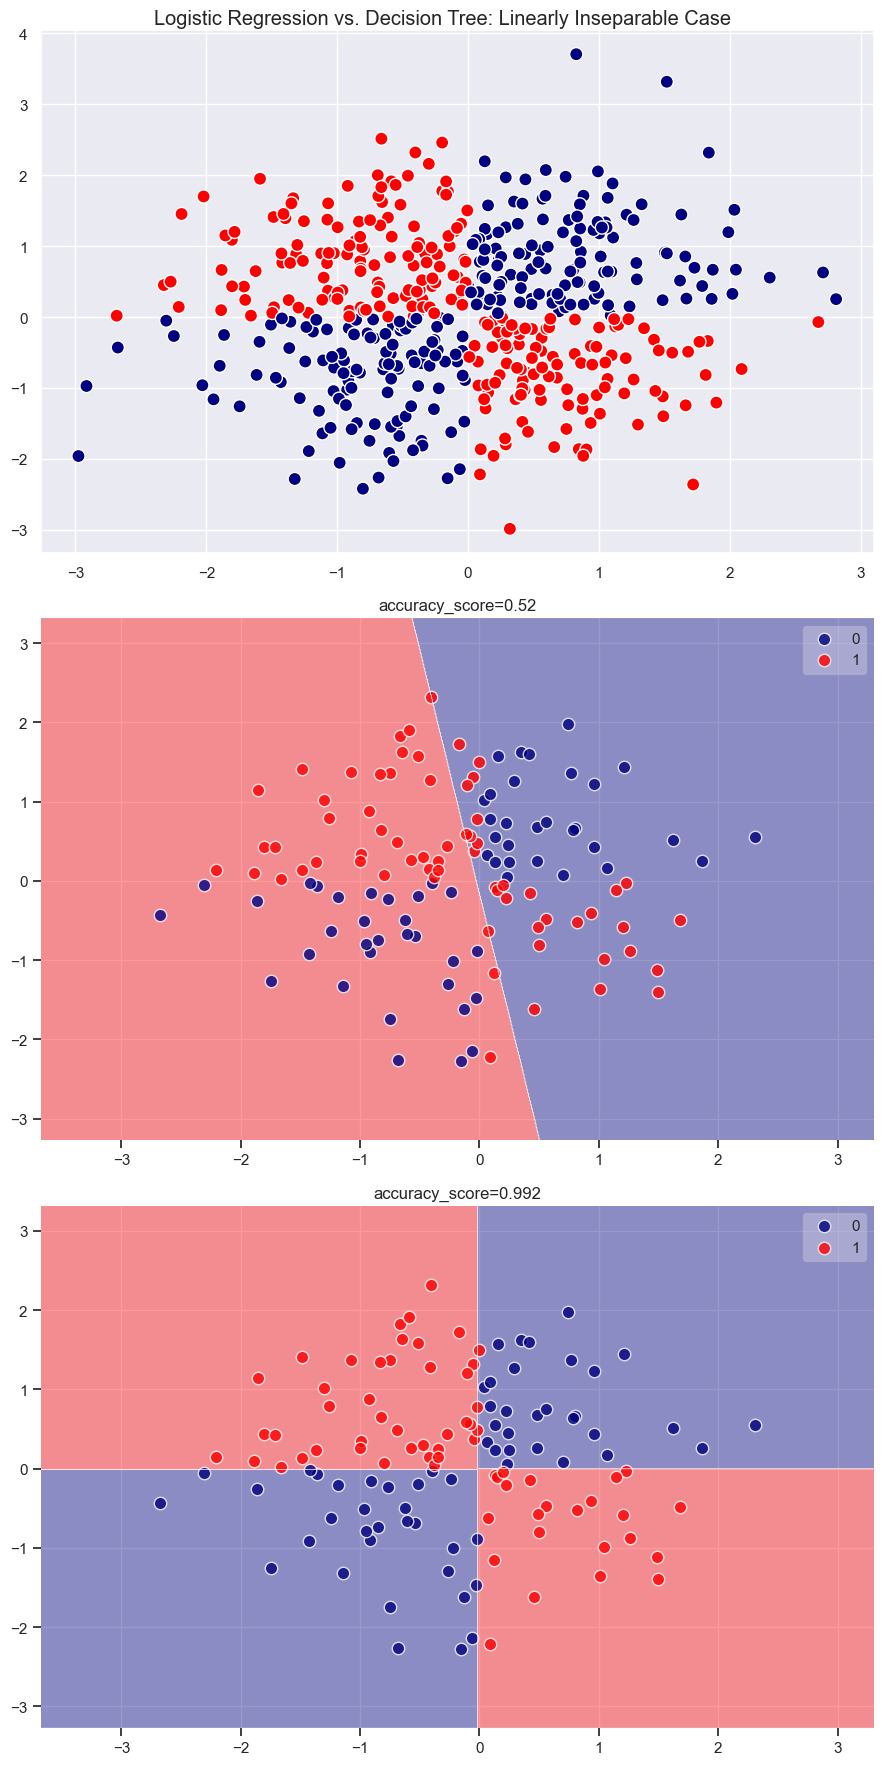

In [40]:
X = norm.rvs(size=(size, 2), random_state=random_state)
y = np.logical_xor(X[:,0] > 0, X[:,1] > 0).astype(int)
logregVsTree(X, y, 'Linearly Inseparable Case')

***
## <a id='toc1_13_'></a>[__Переобучение__](#toc0_)

Рассмотрим влияние гиперпараметров решающего дерева на его структуру:

* __`max_depth`__: максимальная глубина дерева;
* __`min_samples_leaf`__: минимальное число объектов в вершине дерева, необходимое для того, чтобы она стала листом.

In [41]:
size = 100
X = norm.rvs(size=(size, 2), random_state=13)
X[:50,:] += 0.25
X[50:,:] -= 0.25
y = np.array([1]*50 + [0]*50)
colors = np.where(y, 'r', 'navy')

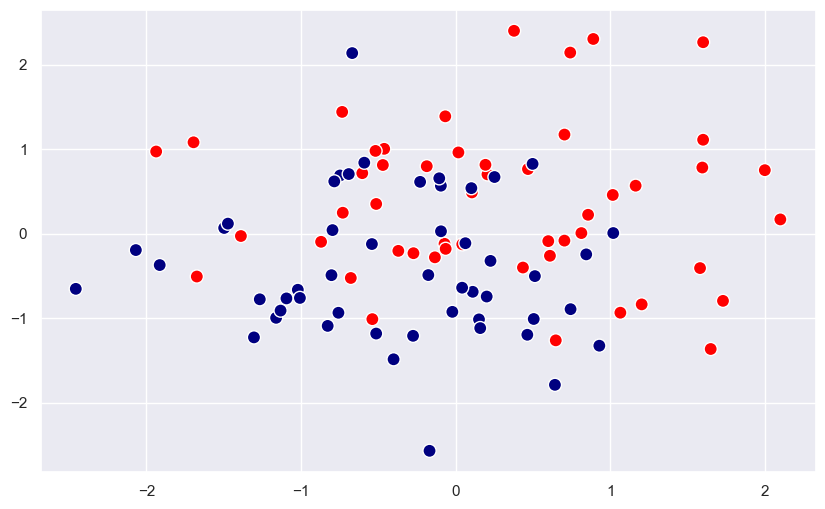

In [42]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0], X[:,1], s=90, c=colors, edgecolor='w')
plt.show()

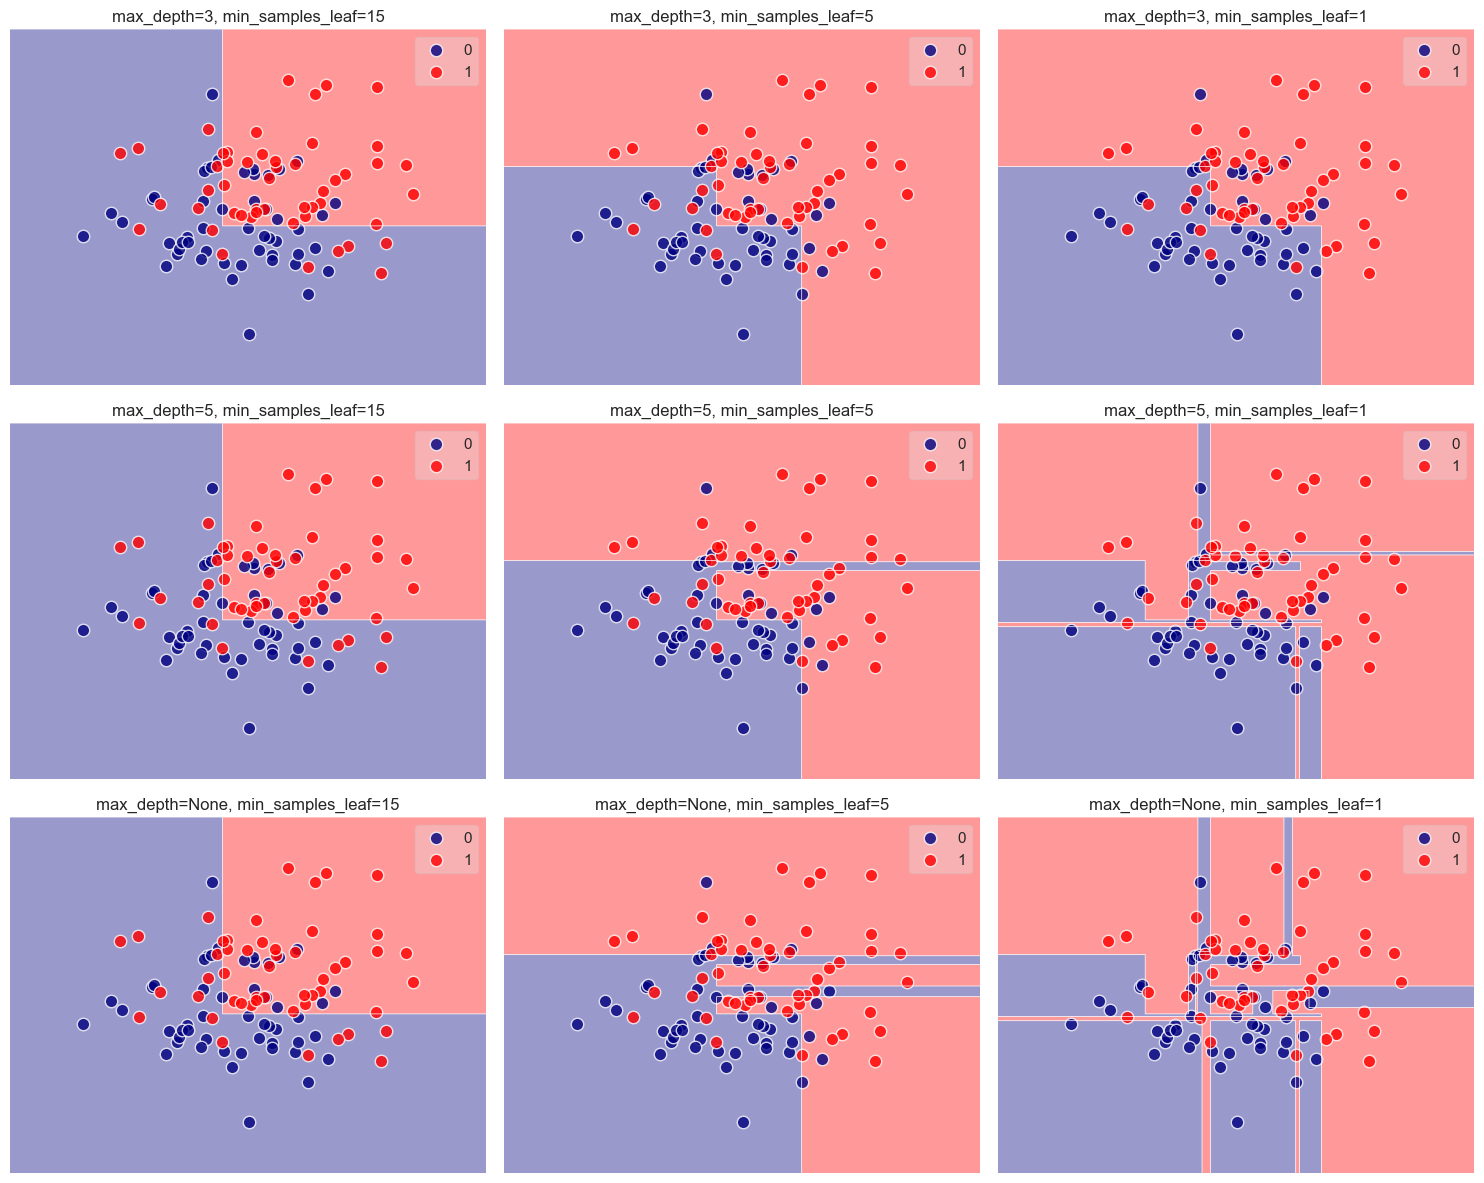

In [43]:
axs = plt.subplots(3, 3, figsize=(15,12))[1]
it = axs.flat

for max_depth, min_samples_leaf in product([3, 5, None], [15, 5, 1]):
    tree = DecisionTreeClassifier(
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf,
        random_state=13
    )
    
    tree.fit(X, y)
        
    ax = next(it)
    ax.set_title(f'{max_depth=}, {min_samples_leaf=}')
    ax.axis('off')
    
    plot_decision_regions(X, y, tree, ax=ax, **regions_kwargs)
    
plt.tight_layout()
plt.show()

На любой выборке, кроме той, где есть объекты с одинаковыми значениями признаков, но разными ответами, можно получить нулевую ошибку с помощью максимально переобученного дерева:

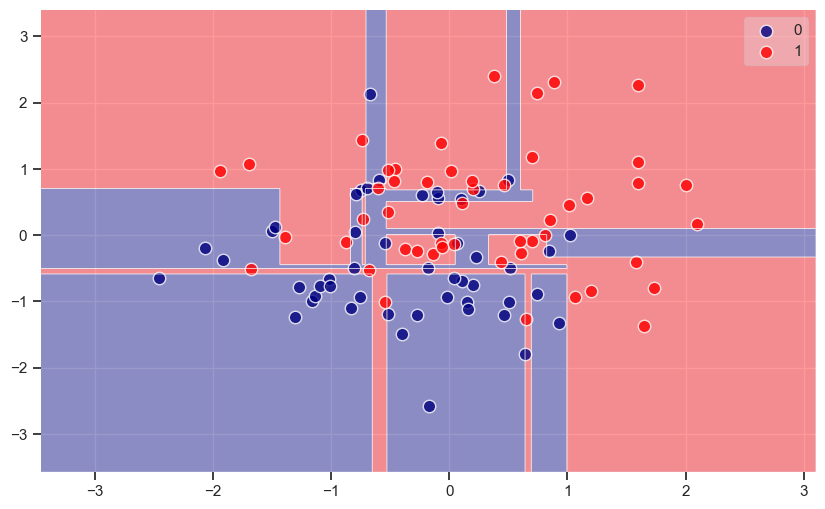

In [44]:
# default: max_depth=None, min_samples_leaf=1
tree = DecisionTreeClassifier(random_state=13)
tree.fit(X, y)

plt.figure(figsize=(10,6))
plot_decision_regions(X, y, tree, **regions_kwargs)
plt.show()

In [45]:
metrics.accuracy_score(y, tree.predict(X))

1.0

***
## <a id='toc1_14_'></a>[__Неустойчивость__](#toc0_)

Продемонстрируем неустойчивость дерева при обучении разными $90\%$-ми подвыборками исходной выборки.

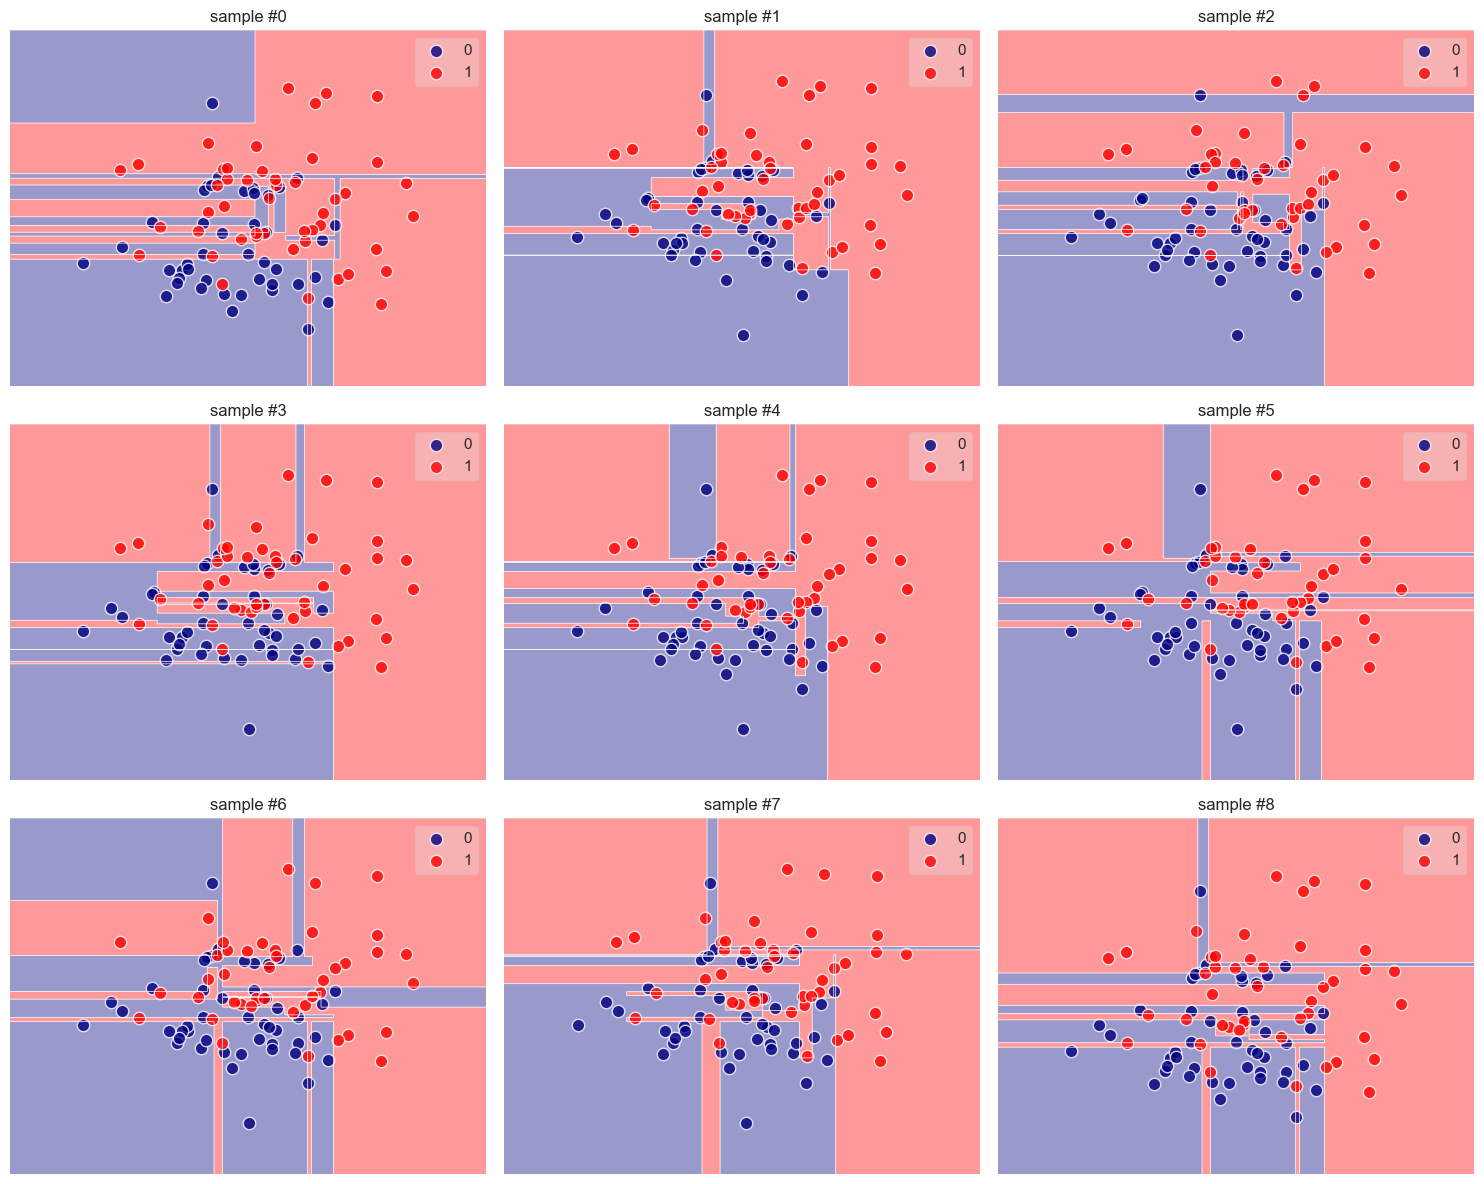

In [46]:
nrows, ncols = 3, 3
axs = plt.subplots(nrows, ncols, figsize=(15,12))[1]
it = axs.flat

for i in range(nrows * ncols):
    Feat, _, resp, _ = train_test_split(X, y, test_size=0.1, random_state=i)
    tree = DecisionTreeClassifier(random_state=13).fit(Feat, resp)
    
    ax = next(it)
    ax.set_title(f'sample #{i}')
    ax.axis('off')
    
    plot_decision_regions(Feat, resp, tree, ax=ax, **regions_kwargs)
    
plt.tight_layout()
plt.show()   